In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import daniel_utils as du
from pandas import *
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn import svm
from sklearn.preprocessing import Imputer
from sklearn.metrics import r2_score
from sklearn.cross_validation import KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

%load_ext autoreload
%autoreload 2
%matplotlib inline

/home/daniel/miniconda3/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
# Import data

df = read_csv(filepath_or_buffer="csv/london.csv", header=0)

df = du.process_df(df)

In [3]:
y = df['L_PREOVULATION'].values

In [4]:
# test_fold = []
# fold_index = 0

# current_id = df.at[0, 'ID']
# for index, row in df.iterrows():
#     if(row['ID'] != current_id):
#         fold_index+=1
#         current_id = row['ID']
#     test_fold.append(fold_index)
    
# #print(len(test_fold))
# #print(test_fold)


In [5]:
df['L_PERIOD'].value_counts()

5.0     10906
6.0      7507
4.0      4636
7.0      2821
3.0      1281
8.0       713
2.0       185
9.0       178
10.0       51
11.0       30
12.0       12
13.0       10
14.0        8
1.0         7
16.0        4
22.0        2
15.0        2
19.0        2
18.0        1
23.0        1
Name: L_PERIOD, dtype: int64

In [6]:
kf = KFold(len(y), n_folds = 10)
len(kf)

10

In [7]:
# drop all non-feature columns
df = df.drop({'ID', 'GROUP_ID', 'CYCLE_ID', 'BIRTH_YR', 'BEGIN_DATE', 'N_GROUPS', 'N_CYCLES', 'DESC', 'TEMP_SCALE', 'CHILDREN'}, axis = 1)
X = df.drop({'L_CYCLE', 'L_PREOVULATION', 'L_PERIOD'}, axis = 1)


Find the number of days of the longest cycle in the group. Drop all the temperature columns that are after that max number of days.

In [8]:
max_l_cycle = int(df['L_CYCLE'].max())
for i in range(max_l_cycle + 1, 100):
    df = df.drop('TEMP' + str(i), axis = 1)

In [9]:
df.to_csv('csv/temp.csv')

Missing values - either fill with zero or impute data

In [10]:
# impute missing data
imp = Imputer(missing_values='NaN', strategy='median', axis=0)
X = imp.fit_transform(X)


In [11]:
from sklearn.cross_validation import PredefinedSplit, cross_val_predict

#originally I was using PredefinedSplit
#ps = PredefinedSplit(test_fold)

#yhat = cross_val_predict(LinearRegression(), X,y=y,cv=kf) # yhat is the predicted values
# for train_index, test_index in ps:
#     #print("TRAIN:", train_index, "TEST:", test_index)
#     X_train, X_test = X[train_index], X[test_index]
#     y_train, y_test = y[train_index], y[test_index]
#     print(len(y_train), len(y_test))
#     model = LinearRegression()
#     model.fit(X_train, y_train)
#     print(model.score(X_test, y_test))

In [13]:
def yhat_process(yhat):
    yhat[yhat<0]=0
    yhat[yhat>50]=50
    return yhat

In [14]:
yhat_lr = cross_val_predict(LinearRegression(), X,y=y,cv=kf)
yhat_lr = yhat_process(yhat_lr)

yhat_ridge = cross_val_predict(Ridge(), X,y=y,cv=kf)
yhat_ridge = yhat_process(yhat_ridge)


yhat_lasso = cross_val_predict(Lasso(), X,y=y,cv=kf)
yhat_lasso = yhat_process(yhat_lasso)



#plt.plot(yhat,y,'.')

# compares yhat(predicted) with y(actual)

In [37]:
yhat_rf = cross_val_predict(RandomForestRegressor(n_estimators=5), X,y=y,cv=kf)
yhat_rf = yhat_process(yhat_rf)

Linear Regression STD: 3.41036164681 Median:  0.26318359375
Ridge STD: 3.36738670657 Median:  0.263861146368
Lasso STD: 3.44618615727 Median:  0.369928157639
Random Forest STD: 2.33115008185 Median:  0.0


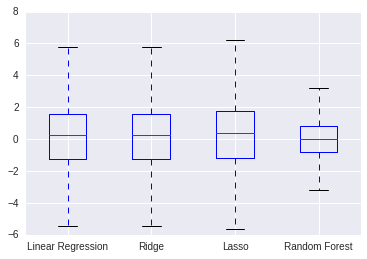

In [38]:
# residuals

#plt.scatter(yhat, yhat-y)
data = [yhat_lr-y, yhat_ridge-y, yhat_lasso-y, yhat_rf-y]
plt.boxplot(data, showfliers=False, labels=('Linear Regression', 'Ridge', 'Lasso', 'Random Forest'))

print('Linear Regression STD:', data[0].std(), 'Median: ', np.median(data[0]))
print('Ridge STD:', data[1].std(), 'Median: ', np.median(data[1]))
print('Lasso STD:', data[2].std(), 'Median: ', np.median(data[2]))
print('Random Forest STD:', data[3].std(), 'Median: ', np.median(data[3]))